In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data
from skimage.measure import LineModelND, ransac
from matplotlib import cm
from tqdm import tqdm

In [3]:
img = skimage.io.imread('https://thewallstreetinn.com/wp-content/themes/thewallstreetinn/images/gallery/WallStreetInn-18.jpg')

## We chose this initial image for testing for the obvious lines in the architecture and multiple vanishing points

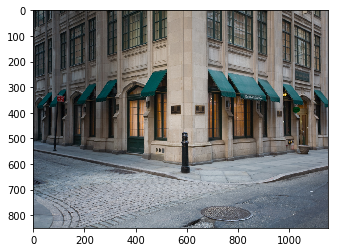

In [4]:
imshow(img)

In [5]:
image = skimage.color.rgb2gray(img)
edges = canny(image)

### The next two cells have code from http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

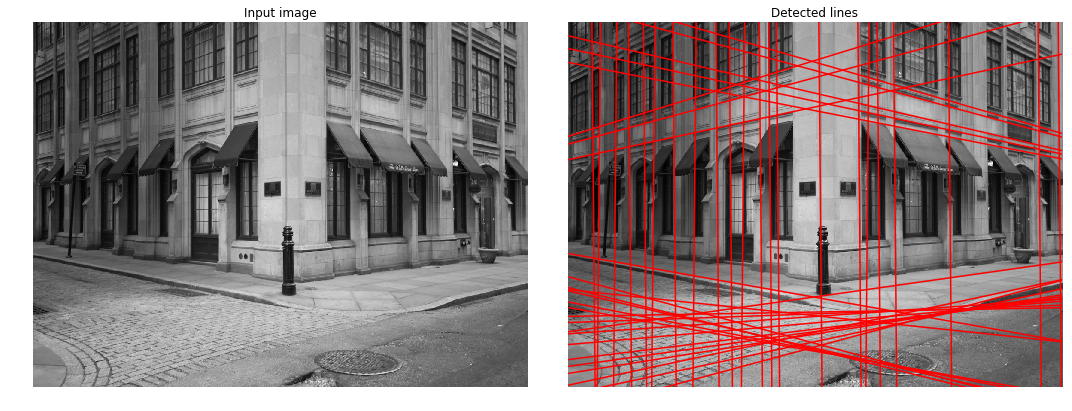

In [6]:
# Classic straight-line Hough transform
h, theta, d = hough_line(edges)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[1].plot((0, image.shape[1]), (y0, y1), '-r')
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

plt.tight_layout()
plt.show()

## In the next cell, we changed line_length to 80, this allowed us to only look at the major lines in the image and avoid lines that would not lead to the vanishing point

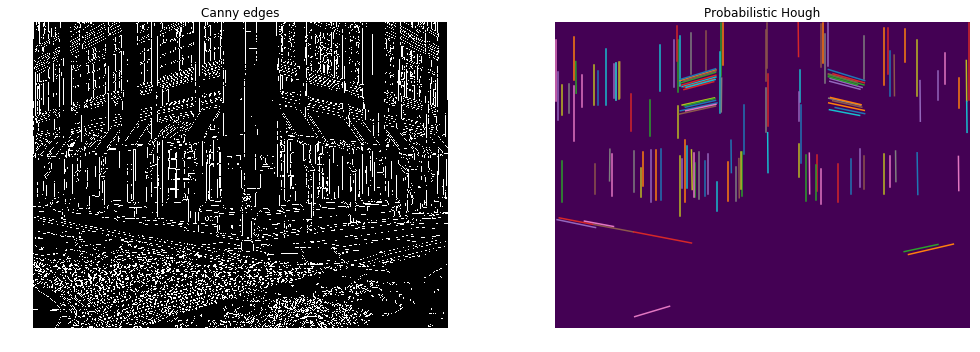

In [7]:
# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=80,
                                 line_gap=2)

# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(edges, cmap=cm.gray)
ax[0].set_title('Canny edges')

ax[1].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## https://stackoverflow.com/questions/3252194/numpy-and-line-intersections

In [8]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [9]:
intersections = []
for i in tqdm(range(len(lines) - 1)):
    for j in range(i+1, len(lines)):
        cur_intersect = get_intersect(lines[i][0], lines[i][1], lines[j][0], lines[j][1])
        # if points are parellel (inf, inf), do not include and go to next iteration
        if(str(cur_intersect[0]) == 'inf'):
            continue
        intersections.append(cur_intersect)
                

100%|██████████| 135/135 [00:01<00:00, 101.26it/s]


## The following figure shows the intersections of lines from the probablistic hough transform

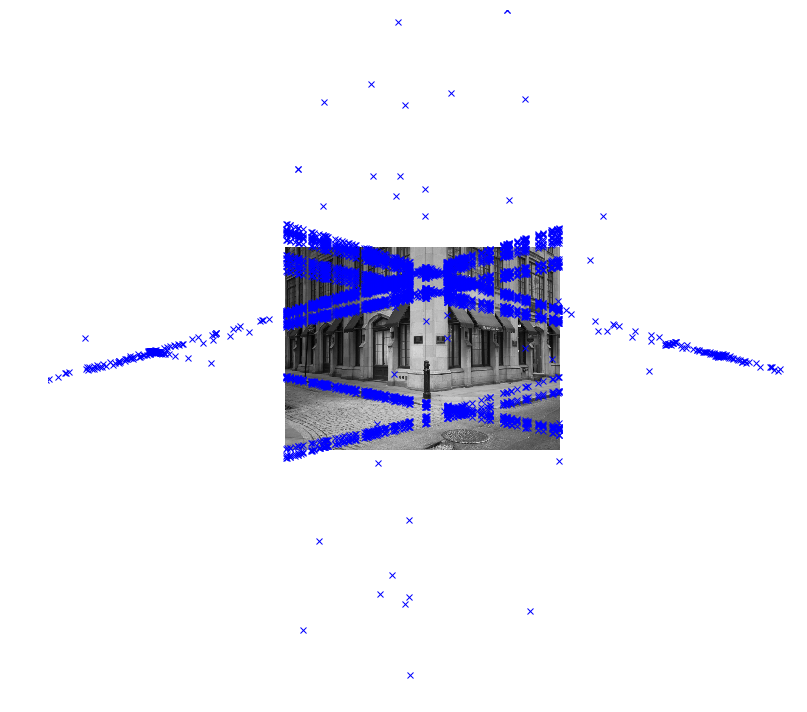

In [10]:
fig, axes = plt.subplots(figsize=(15,10))

axes.imshow(image, cmap=cm.gray)
for i in range(len(intersections)):
    axes.plot(intersections[i][0],intersections[i][1], 'bx', label='point')
axes.set_xlim((-1000, image.shape[1]+1000))
axes.set_ylim((image.shape[0] + 1000, - 1000))
axes.set_axis_off()

plt.tight_layout()
plt.show()

In [11]:
intersections_x = list(zip(*intersections))[0]
intersections_y = list(zip(*intersections))[1]

## http://scikit-image.org/docs/dev/auto_examples/transform/plot_ransac.html#sphx-glr-download-auto-examples-transform-plot-ransac-py

In [12]:
data = np.column_stack([intersections_x, intersections_y])

In [13]:
model = LineModelND()
model.estimate(data)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=10000)
outliers = inliers == False

## The following figure shows the results from the ransac line model estimation on the intersection points from the previous figure

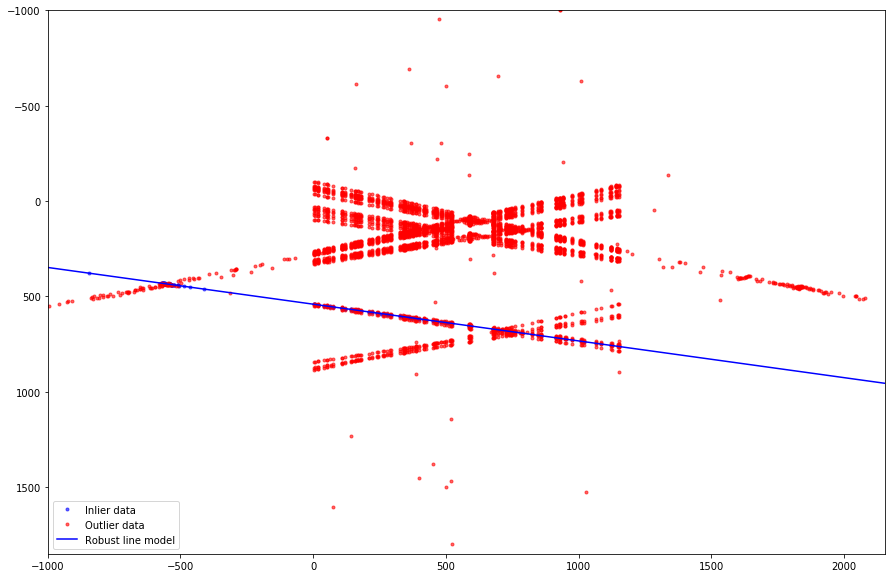

In [14]:
line_x = np.arange(-2500, 2500)
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
        label='Inlier data')
ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6,
        label='Outlier data')
ax.plot(line_x, line_y_robust, '-b', label='Robust line model')
ax.set_xlim((-1000, image.shape[1]+1000))
ax.set_ylim((image.shape[0] + 1000, - 1000))
ax.legend(loc='lower left')
plt.show()